# Background discrimination using the SoLid experiment SM1 module data

## Dr. Antonin Vacheret (avachere@imperial.ac.uk) and Danny Galbinski (d.galbinski19@imperial.ac.uk)



## High Energy Physics Group

## 523 Blackett Lab

 
This project is a typical classification problem in HEP where the experimental data contains large amount of background events and very few signal events (less than ~1% of total). 

The aim is to develop a simpler version of the analysis conducted with the first detector module SM1 to explore various multi-variate models. If you are interested, results from this analysis where published in article below to estimate the background expected for the first phase of the full scale experiment:

https://iopscience.iop.org/article/10.1088/1748-0221/13/05/P05005

The introductory material provided during the course should give you the necessary background to understand the dataset and the approach used to separate the signal and background. The paper is worth a read as it offers more in-depth description of the detector system and the measurements obtained

This exercise is done exclusively in Python and with the aim of introducing the basic classification tools and techniques that are use in most classification problems using some very prowerful library like ```scikit learn```

The project is split in two parts :

* The first part is to learn about the dataset, visualise the data and make sense of the metrics used to optimise the task. It focuses on developing a simple cut and count analysis based on 1 dimensional selection cut
* The second part is about developing the multi-variate analysis using machine learning algorithms like Support Vector Machines or Neural Nets to achieve superiro performance. 


## SoLid Datasets and format ##

The data sets used for the analysis are all saved in numpy arrays. They have been split in multiple datasets with specific running conditions and time selection that will be used to construct the different category of training samples needed for the analysis. More details can be found in the introductionary slides. 

### Antineutrino Monte Carlo simulation dataset
```IBD_sim_signal.npy```: This is the signal prediction dataset. Since it is not possible to use real antineutrino signal as it is the signal we want to extract, we use here the best prediction we have for it using a simulated sample (Geant4 Monte Carlo simulation). The predicted number of antineutrino interactions present in the reactor ON data is ~15 $\bar{\nu_e}$ . 

### SM1 detector datasets

There are two main periods for the data:
* Reactor **off** periods were only background signal is present (no antineutrinos).
* Reactor **on** periods were background **and** signal are present.

There is also two possible time window considered : 
* The **in-time coincidence window** that contains the correlated pair of signal events (Prompt and delayed).  
* The **shifted time coincidence window** where non-correlated backgrounds are present, also called **accidentals**

The combination of these time and data periods can be then split into:  

* Reactor On ```IBD_on_nonshifted.npy```: IBD candidates from the reactor **on** period, so reactor on background plus any signal.

* Reactor Off ```IBD_off_nonshifted.npy```: IBD candidates from the reactor **off** period, so reactor off background only.

* Reactor On Shifted ```IBD_on_shifted.npy```: IBD candidates from the reactor **on** period formed by using **shifted time** windows, therefore *accidental background for reactor on*. 

* Reactor Off Shifted ```IBD_off_shifted.npy```: IBD candidates from the reactor **off** period formed by using **shifted time** windows, therefore *accidental background for reactor off*. 


Each dataset are 2D numpy arrays and although this format is not very general (e.g. compared to having a class for each IBD candidate), it is very convenient for our purposes and numpy arrays computationally perform quickly. The dataset includes 6 variables of interests and each entry has the following structure [and unit]: 

```[delta_t (ns), delta_xy (cubes), delta_z (cubes), delta_r (cubes), volume (cubes), prompt_energy (MeV)]```

A first reduction of the dataset using pre-selection cuts was performed to make these datasets (basically reducing the background already by about a factor of ten to avoid manipulating too large samples). This includes: 
0 < delta_t (us) < 400 ;
prompt_energy > 1 MeV ;
0 <= delta_r <= 5. 

*NB: multiple shifted windows are used to increase the size of the sample, so the absolute rate does not corresponds to the rate expected in reactor on (non-shifted) sample. To scale back to the non-shifted, you will have to multiply the rate by a factor of 0.194.*

*NB: the reactor off runs are 12.2x longer in duration than reactor on.*


This pre-selection can be shown to be over 95% efficient, and for this exercise should be considered fully efficient (i.e. no loss of signal). 

All these datasets have the same format if loaded using the provided functions. Each dataset is a set of IBD candidates, stored as a 2D numpy array. 


## Part I - Learning about the dataset, classification task and simple cut analysis ##

- You can use the scripts provided (or write your own) to start looking at each variable and the differences for each datasets by looking at 1D histograms of the data and various binning size. You can for example also plot correlations between them. 
- What are the variables with the biggest difference between signal and background ? 
- Define some cut value for each variables and compute the $\frac{S}{\sqrt{S+B}}$ ratio which is the metric for the task. How are you going to define the cut values "by hand" ?  
- Once you have a set of selection cuts, Look at what true positive rate and false negative rate this corresponds to and optimise the metric as needed.

Here is an example of a short snippet to plot a specific variable based on the code provided:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# a bit of formating to make the plots looking professional
plt.rcParams['text.usetex'] = 0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18
plt.rcParams.update({'figure.autolayout': True})

import data_getters # class to open the datasets
import mpl_examples #  class to plot

[]

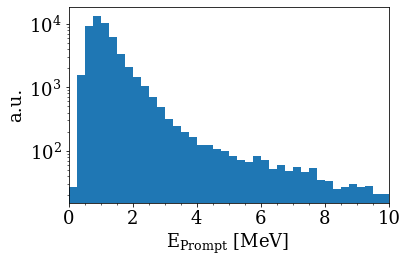

In [2]:
f_name = 'IBD_off_nonshifted.npy'
data = data_getters.get_data(f_name)

x_label = '$\mathregular{E_{Prompt}~[MeV]}$ '
y_label = 'a.u.'

# Plotting now all events from 6th variable in the 2D array between 0 and 10 MeV
ax = mpl_examples.plot_histogram(data[:,5],[0.,10.], 40, x_label, y_label)

ax.minorticks_on()
ax.semilogy()


In [3]:
# Make a density scatter plot to study correlations between variables
import mpl_scatter_density
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax1.scatter_density(data_on_nonshifted[:,5], data_on_nonshifted[:,0], color="red")
ax1.set_xlabel("Prompt Energy [MeV]")
ax1.set_ylabel("\u0394t [ns]")

ModuleNotFoundError: No module named 'mpl_scatter_density'

You could think about how to overlay a few plots and add error bars (statistical ones).

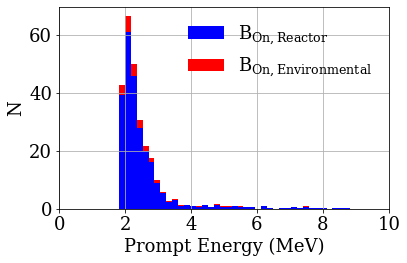

In [5]:
#!python
import IBD

#data_on_nonshifted =data_getters.get_data('IBD_on_nonshifted.npy')
#data_on_shifted = data_getters.get_data('IBD_on_shifted.npy')

# you can also use the function provided to apply specific cuts on the data directly 
data_on_nonshifted = IBD.apply_rt_cuts(data_getters.get_data('IBD_on_nonshifted.npy'))
data_on_shifted = IBD.apply_rt_cuts(data_getters.get_data('IBD_on_shifted.npy'))

# Histogram them all using the same range and number of bins. 
bins_on_shifted, bin_edges = np.histogram(data_on_shifted.T[-1], range = [1, 10], bins = 50)
bins_on_nonshifted, bin_edges = np.histogram(data_on_nonshifted.T[-1], range = [1, 10], bins = 50)

legend_labels = ['$\mathregular{B_{On, Reactor}}$', '$\mathregular{B_{On, Environmental}}$']
all_bin_heights = [0.18*bins_on_shifted - 0.18*0.082*bins_on_shifted, 0.18*0.082*bins_on_shifted]
        
ax = mpl_examples.plot_bar_stack(all_bin_heights, bin_edges, [0, 10], 'Prompt Energy (MeV)', 'N', legend_labels)
ax.legend(frameon=0)

## Part II - Machine learning approach ##

in this second part we are going to compare the simple cut analysis with the machine learning approach. 

- make a flow chart of how you are going to use each datasets to construct the training and test sets for signal and background. 
- Implement a couple of machine learning algorithms of your choice to build a discriminator (SVM, NN, etc...) that returns a probability. Comment on why you have chosen a specific model. You can find some interesting comparison here: 

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

- Optimise the selection analysis based on the $\frac{S}{\sqrt{S+B}}$ metric. Apply it to reactor on data, Do you see any signal ? 